<a href="https://colab.research.google.com/github/volkandemir8/Bilgisayarl-G-r-/blob/main/DonemSonuUygulamasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import kagglehub

path = kagglehub.dataset_download("owm4096/street-objects")

print("Dosya yolu:", path)

Dosya yolu: /kaggle/input/street-objects


In [3]:
dataset_path = "/kaggle/input/street-objects/dataset"
print(os.listdir(dataset_path))

['trafficlight', 'truck', 'limit30', 'car', 'bicycle', 'stop', 'person']


In [4]:
categories = ['bicycle', 'car', 'limit30', 'person', 'stop', 'trafficlight', 'truck']

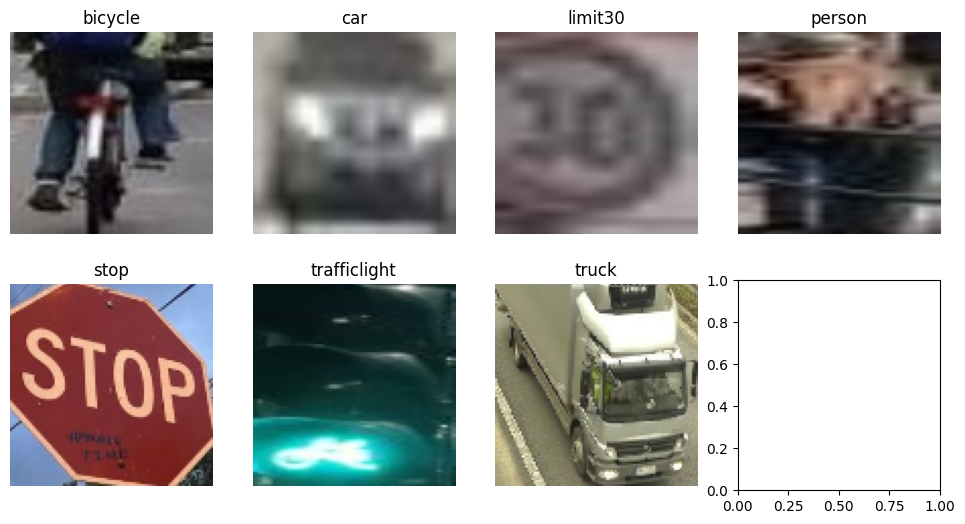

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel() # tek boyutlu hale getiriyor, her subplot’a tek boyutlu indeks ile erişmek için.

for i in range(7):
    category = categories[i]
    img_path = os.path.join(dataset_path, category, os.listdir(os.path.join(dataset_path, category))[i])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (100, 100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis("off")

In [7]:
data= pd.read_csv('/kaggle/input/street-objects/paths.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9879 non-null   int64 
 1   image       9879 non-null   object
 2   label       9879 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 231.7+ KB


In [8]:
data.head()

,Unnamed: 0,image,label
0,0,/kaggle/input/street-objects/dataset/bicycle/1...,0
1,1,/kaggle/input/street-objects/dataset/bicycle/1...,0
2,2,/kaggle/input/street-objects/dataset/bicycle/1...,0
3,3,/kaggle/input/street-objects/dataset/bicycle/1...,0
4,4,/kaggle/input/street-objects/dataset/bicycle/1...,0


In [9]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [10]:
data_train, df_test = train_test_split(data, train_size=0.7, random_state=1, shuffle=True, stratify=data['label'])
data_validation, data_test= train_test_split(df_test, train_size=0.6, random_state=1, shuffle=True, stratify=df_test['label'])

print("Eğitim verisi (train) uzunluğu:", len(data_train))
print("Doğrulama verisi (validation) uzunluğu:", len(data_validation))
print("Test verisi uzunluğu:", len(data_test))

Eğitim verisi (train) uzunluğu: 6915
Doğrulama verisi (validation) uzunluğu: 1778
Test verisi uzunluğu: 1186


In [11]:
BATCH_SIZE = 16
EPOCHS = 10
LEARN_RATE = 0.001

IMG_SIZE = (128, 128)
CLASSES = 7

In [12]:
def pre_process(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

# Görseli oku - Dosya yolundan ham görsel verisini al
# JPEG çözümle - RGB formatına çevir

In [13]:
def create_tf_dataset(df, batch_size):
    paths = df['image'].values
    labels = df['label'].values
    labels = to_categorical(labels, num_classes=CLASSES) # Etiketleri One-Hot Formatına Çevirme

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(pre_process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [14]:
train_dataset = create_tf_dataset(data_train, BATCH_SIZE)
validation_dataset = create_tf_dataset(data_validation, BATCH_SIZE)
test_dataset = create_tf_dataset(data_test, BATCH_SIZE)

In [15]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [16]:
model = create_cnn_model((IMG_SIZE[0], IMG_SIZE[1], 3), CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - accuracy: 0.5250 - loss: 1.3361 - val_accuracy: 0.8318 - val_loss: 0.5189
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.7956 - loss: 0.6345 - val_accuracy: 0.8600 - val_loss: 0.4253
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8452 - loss: 0.4549 - val_accuracy: 0.8718 - val_loss: 0.3937
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8723 - loss: 0.3878 - val_accuracy: 0.8825 - val_loss: 0.3702
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8996 - loss: 0.3078 - val_accuracy: 0.8870 - val_loss: 0.3790
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9183 - loss: 0.2568 - val_accuracy: 0.8993 - val_loss: 0.3436
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9263 - loss: 0.2225 - val_accuracy: 0.9033 - val_loss: 0.3266
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9354 - loss: 0.1895 - 

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9055 - loss: 0.4340
Test Accuracy: 0.91
Test Loss: 0.3678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━

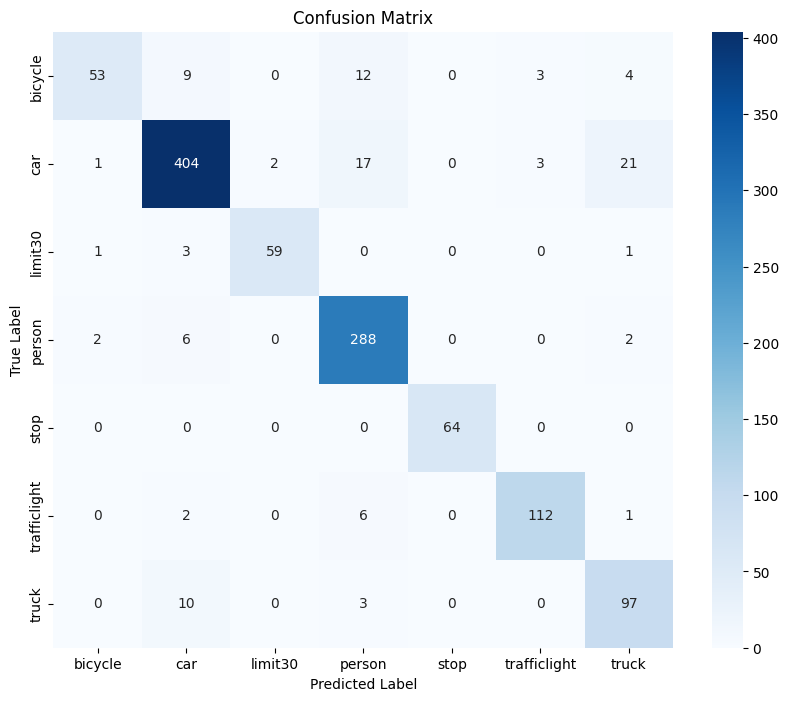

In [35]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=categories, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
predictions = model.predict(test_dataset)

predicted_classes = tf.argmax(predictions, axis=1) # [0.01, 0.05, 0.00, 0.88, 0.03, 0.01, 0.02] → tahmin: sınıf 3

actual_classes = tf.concat([y for x, y in test_dataset], axis=0)
actual_classes = tf.argmax(actual_classes, axis=1) # [0, 0, 0, 1, 0, 0, 0] → 3. sınıf

print(f"Predicted: {predicted_classes.numpy()}")
print(f"Actual: {actual_classes.numpy()}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted: [1 3 1 ... 3 6 1]
Actual: [0 5 1 ... 1 3 6]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


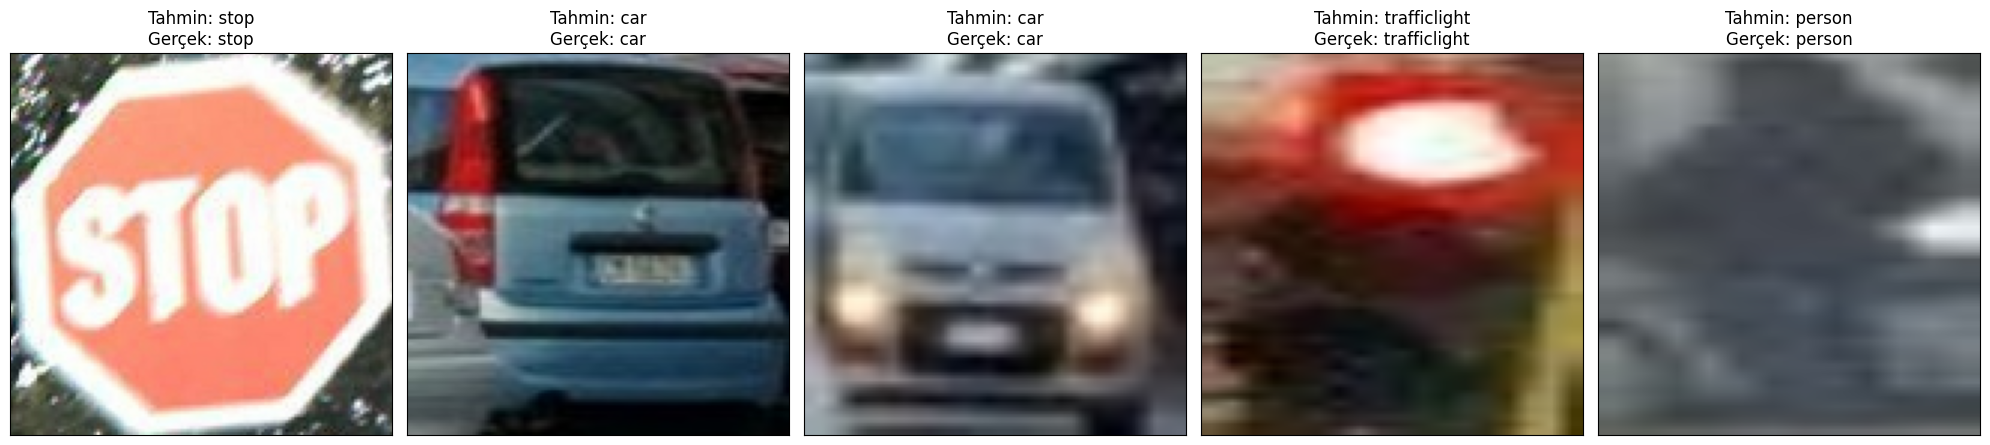

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


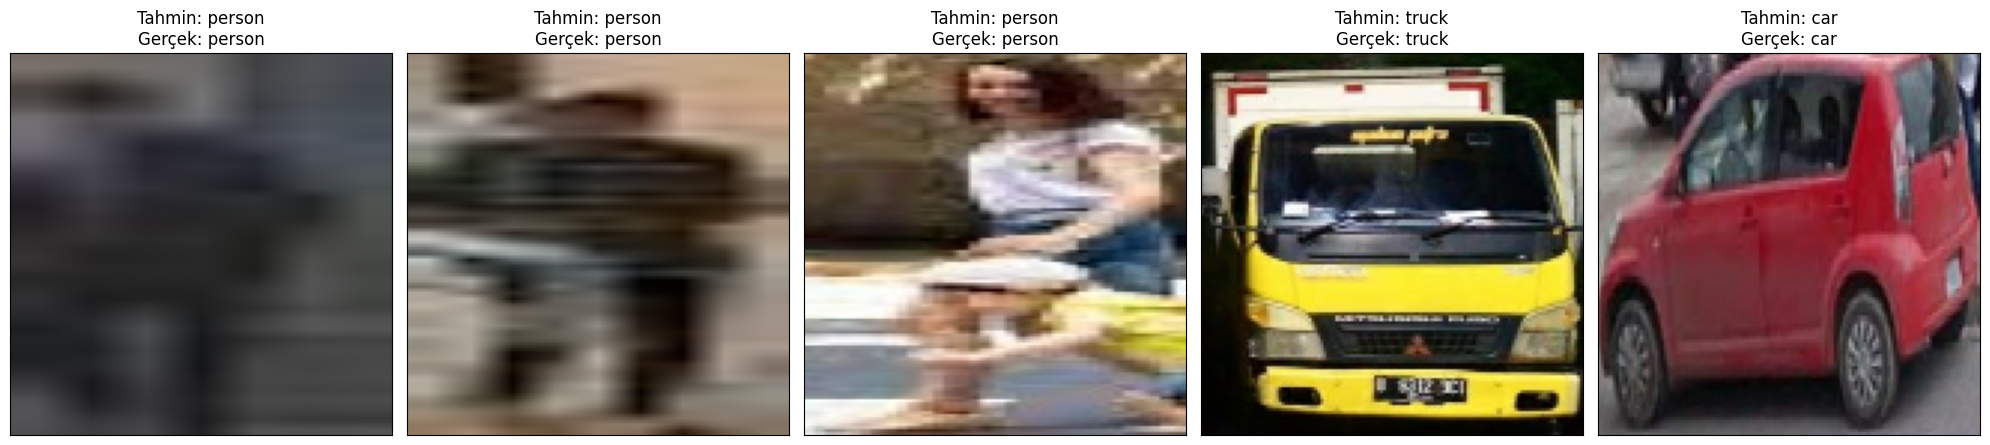

In [27]:
def visualize_predictions(test_dataset, model, images=5):
    dataset_iter = iter(test_dataset)

    for i in range(images):
        image_batch, label_batch = next(dataset_iter)

        predictions = model.predict(image_batch)

        num_to_display = min(5, image_batch.shape[0])

        plt.figure(figsize=(20, 20))
        for j in range(num_to_display):
            plt.subplot(1, num_to_display, j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(image_batch[j])
            predicted_label_id = np.argmax(predictions[j])
            actual_label_id = np.argmax(label_batch[j])

            predicted_label_name = categories[predicted_label_id]
            actual_label_name = categories[actual_label_id]
            plt.title(f"Tahmin: {predicted_label_name}\nGerçek: {actual_label_name}")

        plt.tight_layout()
        plt.show()

visualize_predictions(test_dataset, model, 2)

In [36]:
model.save('model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


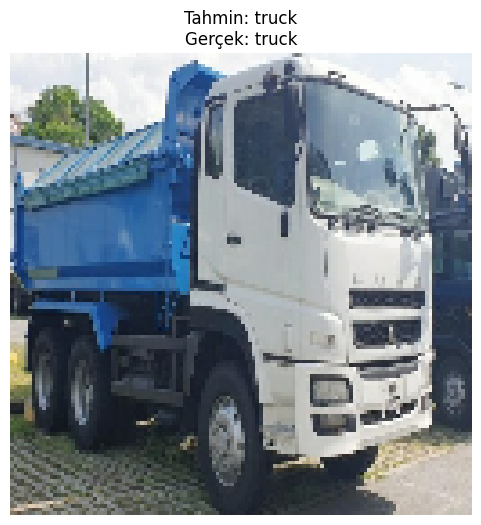

In [ ]:
loaded_model = load_model('model.keras')

for image_batch, label_batch in test_dataset.take(1):
    single_image = image_batch[0]
    single_label = label_batch[0]
    break

single_image = tf.expand_dims(single_image, axis=0)

prediction = loaded_model.predict(single_image)

predicted_label_id = np.argmax(prediction[0])
predicted_label_name = categories[predicted_label_id]

actual_label_id = np.argmax(single_label.numpy())
actual_label_name = categories[actual_label_id]

plt.figure(figsize=(6, 6))
plt.imshow(single_image[0])
plt.title(f"Tahmin: {predicted_label_name}\nGerçek: {actual_label_name}")
plt.axis("off")
plt.show()

In [46]:
def create_cnn_model2(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [47]:
model2 = create_cnn_model2((IMG_SIZE[0], IMG_SIZE[1], 3), CLASSES)
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model2.fit(
    train_dataset,
    epochs=EPOCHS+10,
    validation_data=validation_dataset
)

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.5569 - loss: 9.1386 - val_accuracy: 0.6237 - val_loss: 1.7642
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6658 - loss: 1.0633 - val_accuracy: 0.7452 - val_loss: 1.0083
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7314 - loss: 0.8570 - val_accuracy: 0.5382 - val_loss: 5.5190
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.7459 - loss: 0.8571 - val_accuracy: 0.8476 - val_loss: 0.5445
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.8028 - loss: 0.5890 - val_accuracy: 0.6547 - val_loss: 2.2953
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.7798 - loss: 0.6744 - val_accuracy: 0.8656 - val_loss: 0.4696
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8181 - loss: 0.5928 - val_accuracy: 0.7919 - val_loss: 0.7386
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8310 - loss: 0.4992 - 

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8827 - loss: 0.4669
Test Accuracy: 0.88
Test Loss: 0.4993
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━

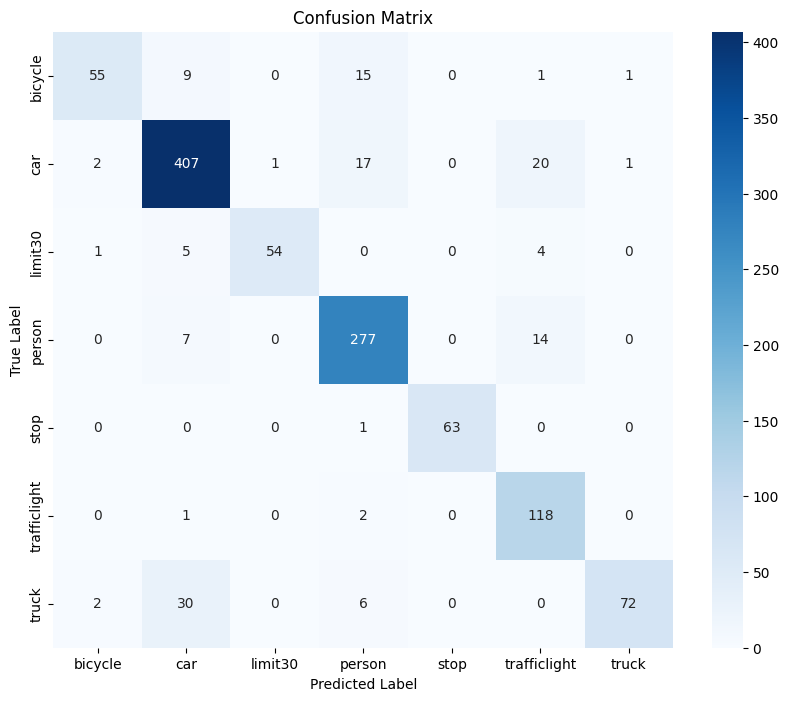

In [50]:
test_loss2, test_accuracy2 = model2.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy2:.2f}")
print(f"Test Loss: {test_loss2:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model2.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=categories, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [51]:
model2.save('model2.keras')

In [54]:
BATCH_SIZE = 32
EPOCHS = 10
LEARN_RATE = 0.0001

In [55]:
train_dataset = create_tf_dataset(data_train, BATCH_SIZE)
validation_dataset = create_tf_dataset(data_validation, BATCH_SIZE)
test_dataset = create_tf_dataset(data_test, BATCH_SIZE)

In [56]:
model3 = create_cnn_model((IMG_SIZE[0], IMG_SIZE[1], 3), CLASSES)
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
model3.fit(
    train_dataset,
    epochs=EPOCHS+10,
    validation_data=validation_dataset
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.4713 - loss: 1.5416 - val_accuracy: 0.7396 - val_loss: 0.8214
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.7135 - loss: 0.8795 - val_accuracy: 0.7666 - val_loss: 0.6747
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.7801 - loss: 0.6693 - val_accuracy: 0.8262 - val_loss: 0.5669
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8119 - loss: 0.5853 - val_accuracy: 0.8442 - val_loss: 0.4712
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8265 - loss: 0.5262 - val_accuracy: 0.8645 - val_loss: 0.4543
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8477 - loss: 0.4736 - val_accuracy: 0.8628 - val_loss: 0.4327
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8632 - loss: 0.4200 - val_accuracy: 0.8684 - val_loss: 0.4055
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8745 - loss: 0.3782 - 

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9257 - loss: 0.2495
Test Accuracy: 0.92
Test Loss: 0.2932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

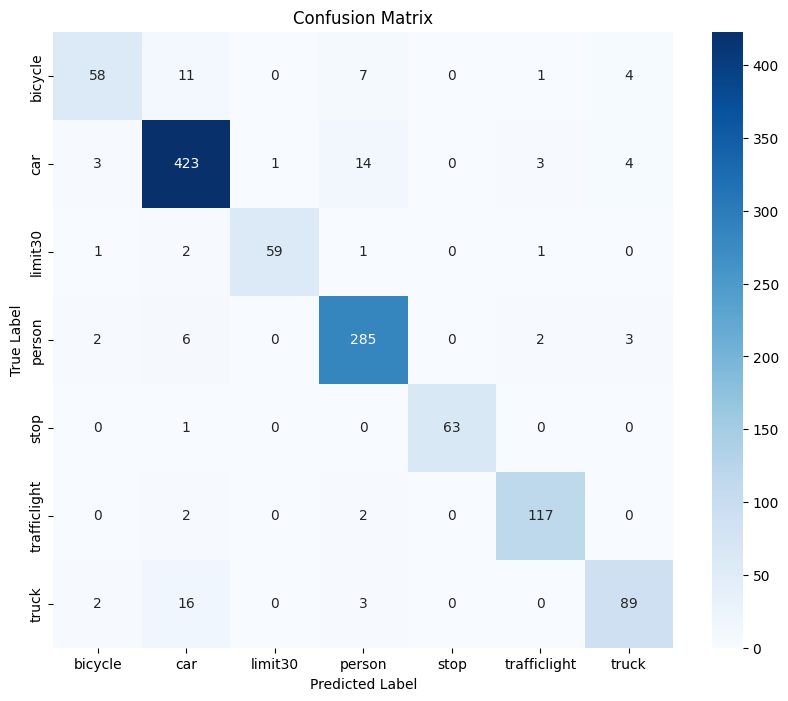

In [59]:
test_loss3, test_accuracy3 = model3.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy3:.2f}")
print(f"Test Loss: {test_loss3:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model3.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=categories, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [60]:
model3.save('model3.keras')

In [61]:
model4 = create_cnn_model2((IMG_SIZE[0], IMG_SIZE[1], 3), CLASSES)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model4.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.6648 - loss: 1.5714 - val_accuracy: 0.1462 - val_loss: 8.4222
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.8751 - loss: 0.3857 - val_accuracy: 0.8330 - val_loss: 0.5591
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9079 - loss: 0.2869 - val_accuracy: 0.8948 - val_loss: 0.3516
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9394 - loss: 0.1970 - val_accuracy: 0.9173 - val_loss: 0.3252
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.9479 - loss: 0.1473 - val_accuracy: 0.9083 - val_loss: 0.3545
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9602 - loss: 0.1246 - val_accuracy: 0.9123 - val_loss: 0.3510
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.9594 - loss: 0.1098 - val_accuracy: 0.9111 - val_loss: 0.4144
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.9653 - loss: 0.1086 -

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9249 - loss: 0.3896
Test Accuracy: 0.92
Test Loss: 0.3723
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━

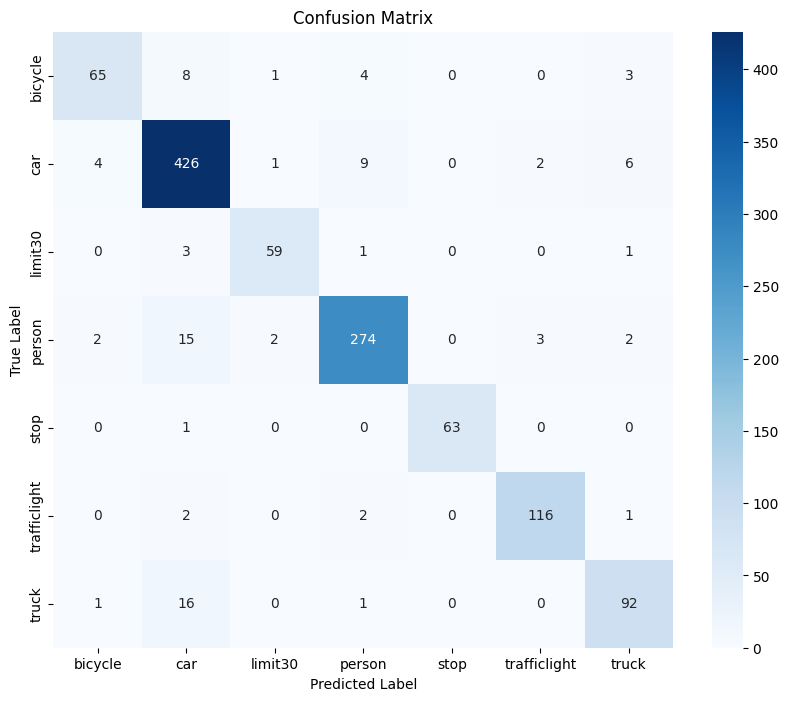

In [64]:
test_loss4, test_accuracy4 = model4.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy4:.2f}")
print(f"Test Loss: {test_loss4:.4f}")

y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model4.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=categories, digits=3))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [65]:
model4.save('model4.keras')